In [1]:
import pandas as pd
import torch#深度学习的pytoch平台
import torch.nn as nn
import numpy as np
import random
import time#可以用来简单地记录时间
import matplotlib.pyplot as plt#画图
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc

from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [2]:
from pyDeepInsight import ImageTransformer
from pyDeepInsight.utils import Norm2Scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [3]:
file_path = '../datasets/mimic/'
df_train = pd.read_csv(file_path + 'train.csv')
df_test = pd.read_csv(file_path + 'test.csv')
df_val = pd.read_csv(file_path + 'val.csv')

In [4]:
np.unique(df_train['death_hosp'], return_counts=True)

(array([0, 1], dtype=int64), array([7750, 1228], dtype=int64))

In [5]:
cat_cols = ["admission_type", 'gender', 'ethnicity', # 'marital_status', "insurance", "language",
            "electivesurgery", "vent",
#             'vasopressor', 'milrinone', 'furosemide',  # 升压药、强心剂、利尿剂
            'activity','fall_risk',
#             'braden_nutrition', 'braden_mobility', 'braden_activity',
#             'lll_lung_sounds','lul_lung_sounds','rll_lung_sounds', 'rul_lung_sounds'
           ]

numerical_cols = ["pre_icu_los_day",'age','weight', #'spo2_fio2_ratio',
                  'bmi', 'creatinine_max', 'bilirubin_max',
                  'platelet_min', 'bun_max', 'wbc_max', 'glucose_max',
                  'hematocrit_max', 'potassium_max', 'sodium_max', 'bicarbonate_min', 'bicarbonate_max',
                  'pao2fio2ratio_vent', 'albumin_min', 'alt_max', 'ast_max', 'alp_max', 'pt_max',
                  'ptt_max', 'inr_min', 'hemoglobin_min', 'chloride_min', 'pao2_min', 'paco2_max', 'lactate_max',
                  'baseexcess_min', 'fio2_max', 'troponin_max', 'lymphocytes_max', 'lymphocytes_min', 'neutrophils_min',
                  'magnesium_max','aniongap_max', 'gcs_min',
                  'urineoutput', 'spo2_min', 'heart_rate_mean', 'mbp_mean',
                  'sbp_mean', 'resp_rate_mean', 'temperature_mean',
                  'cci_score',
                ]

tabular_cols = cat_cols + numerical_cols

In [6]:
X_train = df_train.loc[:, tabular_cols]
X_val = df_val.loc[:, tabular_cols]
X_test = df_test.loc[:, tabular_cols]

y_train = df_train['death_hosp']
y_val = df_val['death_hosp']
y_test = df_test['death_hosp']

# Normalize data using LogScaler

In [7]:
ln = Norm2Scaler()
X_train_norm = ln.fit_transform(X_train)
X_val_norm = ln.transform(X_val)
X_test_norm = ln.transform(X_test)

# Create t-SNE object

In [8]:
distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1
)

Initialize image transformer

In [9]:
pixel_size = ( 8, 8)
it = ImageTransformer(
    feature_extractor=reducer, 
#     feature_extractor='pca',
    pixels=pixel_size)

Train image transformer on training data and transform training and testing sets. Values should be between 0 and 1.

E:\Program_Files\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


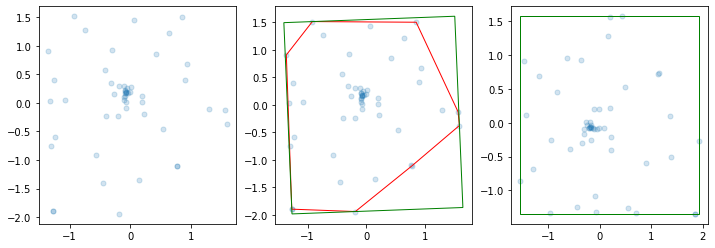

In [10]:
it.fit(X_train, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_val_img = it.transform(X_val_norm)
X_test_img = it.transform(X_test_norm)

The feature density matrix can be extracted from the trained transformer in order to view overall feature overlap

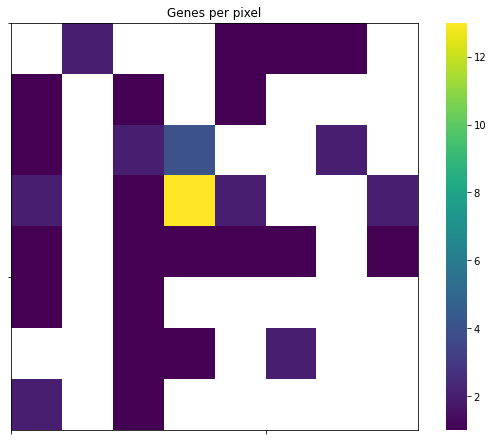

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7.5))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0., 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Genes per pixel")

The following are showing plots for the image matrices first four samples of the training set

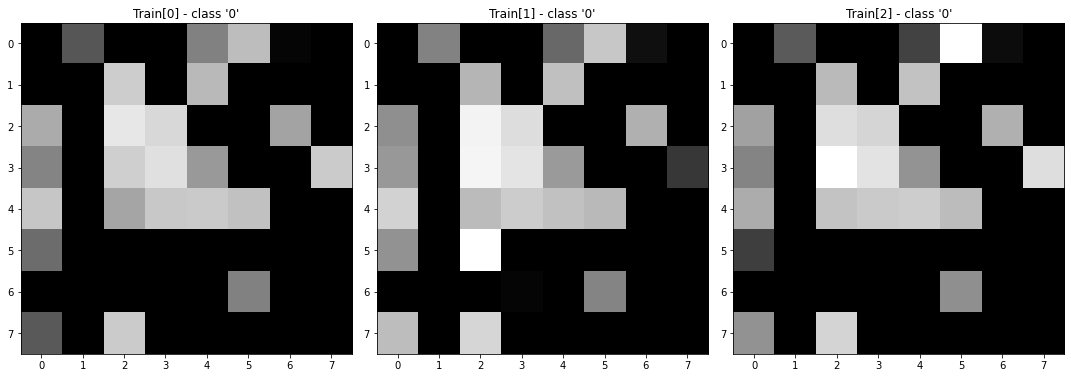

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text(f"Train[{i}] - class '{y_train[i]}'")
plt.tight_layout()

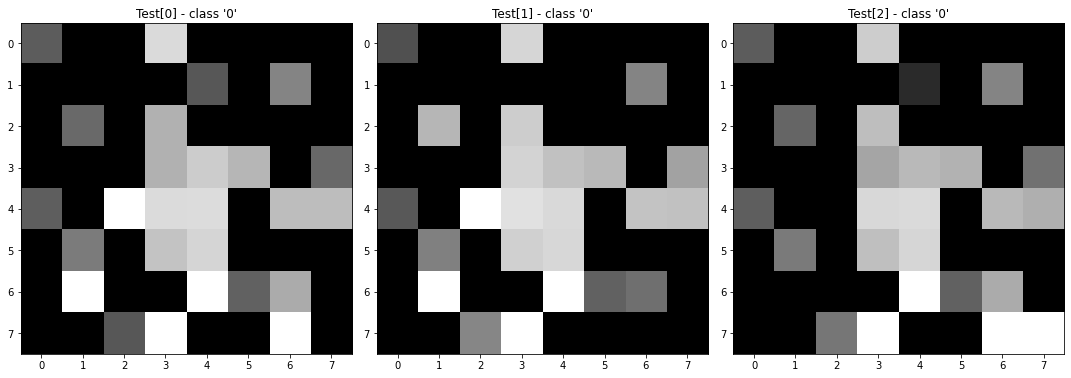

In [13]:
X_test_img = it.transform(X_test_norm)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_test_img[i])
    ax[i].title.set_text(f"Test[{i}] - class '{y_test[i]}'")
plt.tight_layout()

# SqueezeNet

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import warnings; 
warnings.simplefilter('ignore')

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
num_classes = 2
# model = torchvision.models.squeezenet1_1(weights='DEFAULT')
# model.classifier.append(nn.Flatten())
# _ = model.classifier.append(nn.Linear(1000, num_classes))

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()#先找到CNN的父类（比如是类A），然后把类CNN的对象self转换为类A的对象，然后“被转换”的类A对象调用类A对象自己的__init__函数.
        self.conv1 =nn.Sequential(
            #卷积+激活+池化
            #过滤器  高度-filter 用于提取出卷积出来的特征的属性
            #图片的维度是 (1，28，28)1是chanel的维度，28x28的长宽高
            nn.Conv2d(
                3, #in_channels=1图片的高度
                16,#out_channels=16 多少个输出的高度(filter的个数)
                3, #kernel_size=5，filter的高宽都是5个像素点
                1, #stride=1，卷积步长
                2, #padding=2填充，如果想输出的和输入的长宽一样则需要padding=(kernel_size-1)/2
            ), #(16,28,28)
            nn.ReLU(),
            # 删选重要信息，参数(),kernel_size=2,把2x2的区域中选最大的值变成1x1 
            nn.MaxPool2d(kernel_size=2),#(16,14,14)
        )
        #(16,14,14)
        self.conv2=nn.Sequential(
            nn.Conv2d(16,32,5,1,2),#(32,14,14)
            nn.ReLU(),
            #还可以用AvgPool3d，但一般用最大
            nn.MaxPool2d(2),#(32,7,7)
        )
        #输出层 
        self.out=nn.Linear(400,num_classes)#（a，b）a是数据维度 b是分类器有十个
        
    def forward(self,x):
        x=self.conv1(x)
#         x=self.conv2(x)        #(batch,32,7,7)
        x=x.view(x.size(0),-1) #(batch,32*7*7)
        
        output =self.out(x)
        output = torch.softmax(output, 1)
        
        return output

In [17]:
import torchvision.models as models

class resnet_18(nn.Module):
    def __init__(self, num_classes=2):
        super(resnet_18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), stride=(2,2), padding=(3,3), bias=False)
        
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        x = self.resnet18(x)
        
        
        return x

Transform numpy image format to PyTorch tensor. Using an untrained network, so normalization as specificed in SqueezeNet documentation is not required.

In [18]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [19]:
X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float()
y_train_tensor = torch.from_numpy(np.array(y_train))

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float()
y_test_tensor = torch.from_numpy(np.array(y_test))

In [20]:
batch_size = 64

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [21]:
# model = CNN()
model = resnet_18()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-04,
    #momentum=0.8,
    weight_decay=1e-05
)

In [22]:
model.train()
model.to(device)
for epoch in range(20):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')

[0] loss: 0.414
[19] loss: 0.308


Calculate accuracy of prediction

In [23]:
model.to('cpu')
model = model.eval()

In [24]:
with torch.no_grad():
    y_hat = model(X_train_tensor)
train_predicted = torch.max(y_hat, 1)[1]
train_prob = y_hat

In [25]:
train_prob.shape

torch.Size([8978, 2])

In [26]:
with torch.no_grad():
    y_hat = model(X_test_tensor)
test_predicted = torch.max(y_hat, 1)[1]
test_prob = y_hat

In [27]:
print(f"The train accuracy was {accuracy_score(train_predicted, y_train_tensor):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, y_test_tensor):.3f}")
print("\n")
print(f"The train auc was {roc_auc_score( y_train_tensor, train_prob[:, 1]):.3f}")
print(f"The test auc was {roc_auc_score( y_test_tensor, test_prob[:, 1]):.3f}")

The train accuracy was 0.881
The test accuracy was 0.854


The train auc was 0.854
The test auc was 0.748


In [28]:
train_predicted.shape

torch.Size([8978])

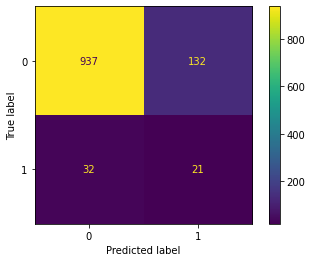

In [29]:
_ = ConfusionMatrixDisplay.from_predictions(test_predicted, y_test_tensor, display_labels=np.array([0,1]))

In [30]:
df_external = pd.read_csv(file_path + 'external.csv')
df_temporal = pd.read_csv(file_path + 'mimiciv_temporal_data_preprocess.csv')

In [31]:
X_external = df_external.loc[:, tabular_cols]
X_temp = df_temporal.loc[:, tabular_cols]

y_external= df_external['death_hosp']
y_temp = df_temporal['death_hosp']

In [32]:
X_external_norm = ln.transform(X_external)
X_temp_norm = ln.transform(X_temp)

In [33]:
X_external_img = it.transform(X_external_norm)
X_temp_img = it.transform(X_temp_norm)

In [34]:
X_external_tensor = torch.stack([preprocess(img) for img in X_external_img]).float()
y_external_tensor = torch.from_numpy(np.array(y_external))

X_temp_tensor = torch.stack([preprocess(img) for img in X_temp_img]).float()
y_temp_tensor = torch.from_numpy(np.array(y_temp))

In [35]:
externalset = TensorDataset(X_external_tensor, y_external_tensor)
externalloader = DataLoader(externalset, batch_size=batch_size, shuffle=False)

tempset = TensorDataset(X_temp_tensor, y_temp_tensor)
temploader = DataLoader(tempset, batch_size=batch_size, shuffle=False)

In [36]:
with torch.no_grad():
    y_hat = model(X_external_tensor)
external_predicted = torch.max(y_hat, 1)[1]
external_prob = y_hat

with torch.no_grad():
    y_hat = model(X_temp_tensor)
temp_predicted = torch.max(y_hat, 1)[1]
temp_prob = y_hat

In [37]:
print(f"The external accuracy was {accuracy_score(external_predicted, y_external_tensor):.3f}")
print(f"The temporal accuracy was {accuracy_score(temp_predicted, y_temp_tensor):.3f}")
print("\n")
print(f"The external auc was {roc_auc_score( y_external_tensor, external_prob[:, 1]):.3f}")
print(f"The temporal auc was {roc_auc_score( y_temp_tensor, temp_prob[:, 1]):.3f}")

The external accuracy was 0.849
The temporal accuracy was 0.861


The external auc was 0.671
The temporal auc was 0.787
